# 5.2 EKF Localization

The Kalman filter is one of the best studied techniques for filtering and prediction of linear systems. Among its virtues, it provides a way to overcome the occasional un-observability problem of the Least Squares approach. Nevertheless, it makes a strong assumption that the two involved process equations (state transition and observation) are linear. 

Unfortunately, you should already know that our system of measurements (i.e. the observation function) and motion (i.e. pose composition) are non-linear.
Therefore, this notebook focuses from the get-go on the **Extended Kalman Filter**, which is adapted to work with non-linear systems.

The EKF algorithm consists of 2 phases: **prediction** and **correction**.

$$
  \begin{aligned}
      \verb!def !& \verb!ExtendedKalmanFilter!(\mu_{t-1},\Sigma_{t-1}, u_t, z_t): \\
      & \textbf{Prediction.} \\
      & \bar\mu_t = g(\mu_{t-1}, u_t) = \mu_{t-1} \oplus u_t &\text{(1. Pose prediction)}\\
      & \bar\Sigma_t = G_t \Sigma_{t-1} G_t^T + R_t &\text{(2. Uncertainty of prediction)}\\
      & \textbf{Correction.} \\
      & K_t = \bar\Sigma_t H^T_t (H_t \bar\Sigma_t H^T_t + Q_t)^{-1} &\text{(3. Kalman gain)}\\
      & \mu_t = \bar\mu_t + K_t (z_t - h(\bar\mu_t)) &\text{(4. Pose estimation)}\\
      & \Sigma_t = (I - K_t H_t) \bar\Sigma_t &\text{(5. Uncertainty of estimation)}\\
      & \verb!return ! \mu_t, \Sigma_t
  \end{aligned}
$$

Notice that $R_t$ is the covariance of the motion $u_t$ in the coordinate system of the predicted pose $(\bar x_t)$, then (Note: $J_2$ is our popular Jacobian for the motion command, you could also use $J_1$):

$$R_t = J_2 \Sigma_{u_t} J_2^T \quad\text{with}\quad J_2 = \frac{\partial g(\mu_{t-1}, u_t)}{\partial u_t}$$

Where:

  - $(\mu_t, \Sigma_t)$ represents our robots pose, so $x_t \sim N(\mu_t, \Sigma_t)$
  - $(u_t, \Sigma_{u_t})$ is the motion command received, and its respective uncertainty.
  - $(z_t, Q_t)$ are the observations taken, and their covariance.
  - $G_t$ and $H_t$ are the Jacobians of the motion model and the observation model respectively:

$$G_t = \frac{\partial g(\mu_{t-1}, u_t)}{\partial x_{t-1}}, \qquad H_t = \frac{\partial h(\bar\mu_t)}{\partial x_t}$$

In this notebook we are going to play with the EKF localization algorithm using a map of landmarks and a sensor providing range and bearing measurements from the robot pose to such landmarks. Concretely, **we are going to**:
1. Implement a class modeling a **range and bearing sensor** able to take measurements to landmarks.
2. Complete a class that implements the robot behavior after completing **motion commands**.
3. Implement the **Jacobian of the observation model**.
4. With the previous building blocks, implement our own **EKF filter** and see it in action.
5. Finally, we are going to consider a more **realistic sensor** with a given Field of View and a maximum operational range. 

In [1]:
# IMPORTS
import numpy as np
from numpy import random
from numpy import linalg
import matplotlib
matplotlib.use('TkAgg')
from matplotlib import pyplot as plt
from IPython.display import display, clear_output
import time

import sys
sys.path.append("..")
from utils.AngleWrap import AngleWrapList
from utils.PlotEllipse import PlotEllipse
from utils.Drawings import DrawRobot, drawFOV, drawObservations
from utils.Jacobians import J1, J2
from utils.tcomp import tcomp

### **<span style="color:green"><b><i>ASSIGNMENT 1: Getting an observation to a random landmark</i></b></span>** 


We are going to implement the `Sensor()` class modelling a range and bearing sensor. Recall that the observation model of this type of sensos is:

$$
z_i= \begin{bmatrix} d_i \\ \theta_i \end{bmatrix}=h(m_i,x)=
\begin{bmatrix} \sqrt{(x_i-x)^2+(y_i-y)^2} \\ atan\left(\frac{y_i-y}{x_i-x}\right) - \theta \end{bmatrix}+w_i
$$

where $m_i=[x_i,y_i]$ are the landmark coordinates in the world frame, $x=[x,y,\theta]$ is the robot pose, and the noise $w_i$ follows a Gaussian distribution with zero mean and covariance matrix:

$$\Sigma_S = 
    \begin{bmatrix}
        \sigma^2_r & 0 \\
        0 & \sigma^2_{\theta}
    \end{bmatrix}
$$

For that, complete the following methods:
- `observe()`: which, given a real robot pose (`from_pose`), returns the measurments to the landmarks in the map (`world`). If `noisy=true`, then a random gaussian noise with zero mean and covariance $\Sigma_S$ (`cov`) is added to each measurement. *Hint you can use [`random.randn()`](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.randn.html) for that.*

- `random_observation()`: that, given again the robot pose (`from_pose`), randomly selects a landmark from the map (`world`) and returns an observation from the range-bearing sensor using the `observe()` method previously implemented. The `noisy` argument is just passed to `observe()`.  *Hint: to randomly select a landmark, use [`randint()`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randint.html).*

In [2]:
class Sensor():
    def __init__(self, cov):
        """
        Args:
            cov: covariance of the sensor.
        """
        self.cov = cov
    
    def observe(self, from_pose, world, noisy=True, flatten=True):
        """Calculate observation relative to from_pose

        Args:
            from_pose: Position(real) of the robot which takes the observation
            world: List of world coordinates of some landmarks
            noisy: Flag, if true then add noise (Exercise 2)

        Returns:
                Numpy array of polar coordinates of landmarks from the perspective of our robot
                They are organised in a vertical vector ls = [d_0 , a_0, d_1, ..., a_n]'
                Dims (2*n_landmarks, 1) 
        """
        delta = world - from_pose[0:2]

        z = np.empty_like(delta)
        z[0, :] = np.sqrt(delta[0] ** 2 + delta[1] ** 2)
        z[1, :] = np.arctan(delta[1] / delta[0]) - from_pose[2]
        z[1, :] = AngleWrapList(z[1, :])

        if noisy: 
            z += np.sqrt(self.cov) @ random.randn(2, z.shape[1])

        if flatten:
            return np.vstack(z.flatten('F'))
        else:
            return z
        
    def random_observation(self, from_pose, world, noisy=True):
        """ Get an observation from a random landmark 
            
            Args: Same as observe().
                
            Returns:
                z: Numpy array of obs. in polar coordinates
                landmark: Index of the randomly selected landmark in the world map
                    Although it is only one index, you should return it as
                    a numpy array.
        """
        n_landmarks = world.shape[1]
        rand_idx = np.random.randint(0, n_landmarks)
        world = world[:, [rand_idx]]
        
        z = self.observe(from_pose, world, noisy)

        return z, np.array([rand_idx])

You can use the code cell below **to test your implementation**.

In [3]:
# TRY IT!
seed = 0
np.random.seed(seed)

# Sensor characterization
SigmaR = 1 # Standard deviation of the range
SigmaB = 0.7 # Standard deviation of the bearing
Q = np.diag([SigmaR**2, SigmaB**2]) # Cov matrix

sensor = Sensor(Q)

# Map
Size = 50.0
NumLandmarks = 3
Map = Size*2*random.rand(2,NumLandmarks)-Size

# Robot true pose
true_pose = np.vstack([-Size+Size/3, -Size+Size/3, np.pi/2])

# Take a random measurement
noisy = False
z = sensor.random_observation(true_pose, Map, noisy)

noisy = True
noisy_z = sensor.random_observation(true_pose, Map, noisy)

# Take observations to every landmark in the map
zs = sensor.observe(true_pose, Map, noisy)

print('Measurement:\n' + str(z))
print('Noisy measurement:\n' + str(noisy_z))
print('Measurements to every landmark in the map:\n' + str(zs))

Measurement:
(array([[53.76652662],
       [-0.79056712]]), array([0]))
Noisy measurement:
(array([[64.73997127],
       [-0.81342958]]), array([2]))
Measurements to every landmark in the map:
[[ 5.51319938e+01]
 [-1.10770618e+00]
 [ 6.04762304e+01]
 [-1.46219661e+00]
 [ 6.23690518e+01]
 [-5.72010701e-02]]


<span style="color:blue">Expected output</span>

```
Measurement:
(array([[53.76652662],
       [-0.79056712]]), array([0]))
Noisy measurement:
(array([[64.73997127],
       [-0.81342958]]), array([2]))
Measurements to every landmark in the map:
[[ 5.51319938e+01]
 [-1.10770618e+00]
 [ 6.04762304e+01]
 [-1.46219661e+00]
 [ 6.23690518e+01]
 [-5.72010701e-02]]
 ```

### **<span style="color:green"><b><i>ASSIGNMENT 2: Simulating the robot motion</i></b></span>** 
In the robot motion chapter we commanded a mobile robot to follow a squared trajectory. We provide here the `Robot` class that implements:
- how the robot pose evolves after executing a motion command (`step()` method), and
- the functionality needed to graphically show its ideal pose (`pose`), true pose (`true_pose`) and estimated pose (`xEst`) in the `draw()` function.

Your mission is to complete the `step()`method by adding random noise to each motion command (`noisy_u`) based on the following covariance matrix, and update the true robot pose (`true_pose`):

$$\Sigma_{u_t} = 
    \begin{bmatrix}
        \sigma^2_{\Delta x} & 0 & 0\\
        0 & \sigma^2_{\Delta y} & 0\\
        0 & 0 & \sigma^2_{\Delta \theta}
    \end{bmatrix}
$$ 

*Hint: Recall again the [`random.randn()`](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.randn.html) function.*

In [4]:
class Robot():
    def __init__(self, true_pose, cov_move):
        # Robot description (Starts as perfectly known)
        self.pose = true_pose
        self.true_pose = true_pose
        self.cov_move = cov_move

        # Estimated pose and covariance
        self.xEst = true_pose
        self.PEst = np.zeros((3, 3))
        
    def step(self, u):
        self.pose = tcomp(self.pose,u) # New pose without noise
        noise = np.sqrt(self.cov_move)@random.randn(3,1) # Generate noise
        noisy_u = u + noise #  Apply noise to the control action
        self.true_pose = tcomp(self.true_pose, noisy_u) #  New noisy pose (real robot pose)
        
    def draw(self, fig, ax):
        DrawRobot(fig, ax, self.pose, color='r')
        DrawRobot(fig, ax, self.true_pose, color='b')
        DrawRobot(fig, ax, self.xEst, color='g')
        PlotEllipse(fig, ax, self.xEst, self.PEst, 4, color='g')

It is time **to test** your `step()` function!

In [5]:
# Robot base characterization
SigmaX = 0.8 # Standard deviation in the x axis
SigmaY = 0.8 # Standard deviation in the y axis
SigmaTheta = 0.1 # Bearing standar deviation
R = np.diag([SigmaX**2, SigmaY**2, SigmaTheta**2]) # Cov matrix

# Create the Robot object
true_pose = np.vstack([2,3,np.pi/2])
robot = Robot(true_pose, R)

# Perform a motion command
u = np.vstack([1,2,0])
np.random.seed(0)
robot.step(u)

print('robot.true_pose.T:' + str(robot.true_pose.T) + '\'')

robot.true_pose.T:[[-0.32012577  5.41124188  1.66867013]]'


<span style="color:blue">Expected output</span>

```
robot.true_pose.T:[[-0.32012577  5.41124188  1.66867013]]'
```

### **<span style="color:green"><b><i>ASSIGNMENT 3:  Jacobians of the observation model</i></b></span>** 

Given that the position of the landmarks in the map is known, we can use this information in a Kalman filter, in our case an EKF. For that we need to implement the **Jacobians of the observation model**, as required by the correction step of the filter. 

Implement the function `getObsJac()`that given:
- the predicted pose in the first step of the Kalman filter, 
- a number of observed landmarks, and 
- the map, 

returns such Jacobian. Recall that, for each observation to a landmark:

$$
\nabla H = \frac{\partial h}{\partial \{x,y,\theta \}} =
\begin{bmatrix}
    -\frac{x_i - x}{d} & - \frac{y_i - y}{d} & 0 \\
    \frac{y_i - y}{d^2} & -\frac{x_i - x}{d^2} & -1
\end{bmatrix}_{2 \times 3}
$$

Recall that $[x_i,y_i]$ is the position of the $i^{th}$ landmark in the map, $[x,y]$ is the robot predicted pose, and $d$ the distance from such predicted pose to the landmark. This way, the resultant Jacobian dimensions are $(\#observed\_landmarks \times 2, 3)$, that is, the Jacobians are stacked vertically to form the matrix $H$.

In [6]:
def getObsJac(xPred, lm, Map): 
    """ Obtain the Jacobian for all observations.

        Args:
            xPred: Position of our robot at which Jac is evaluated.
            lm: Numpy array of observations to a number of landmarks (indexes in map)
            Map: Map containing the actual positions of the observations.

        Returns:
            jH: Jacobian matrix (2*n_landmaks, 3) 
    """
    n_land = len(lm)
    jH = np.empty((2*n_land,3))
    
    for i in range(n_land):
        # Auxiliary variables
        dx = Map[0,lm[i]] - xPred[0,0]
        dy = Map[1,lm[i]] - xPred[1,0]
        d = np.sqrt(dx ** 2 + dy ** 2)
        d2 = d ** 2
        
        ii = 2*i

        # Build the Jacobian
        jH[ii:ii+2,:] = [
            [-dx/d, -dy/d, 0],
            [dy/d2, -dx/d2, -1]
        ]

    return jH

Time **to check** your function!

In [7]:
# TRY IT!

observed_landmarks = np.array([0,2])
xPred = np.vstack([-Size+Size/3, -Size+Size/3, np.pi/2]) # Robot predicted pose
jH = getObsJac(xPred, observed_landmarks, Map) # Retrieve the evaluated observation jacobian

print ('Jacobian dimensions: ' + str(jH.shape) )
print ('jH:' + str(jH))

Jacobian dimensions: (4, 3)
jH:[[-0.71075232 -0.70344235  0.        ]
 [ 0.01308328 -0.01321923 -1.        ]
 [-0.67304061 -0.73960552  0.        ]
 [ 0.01141455 -0.01038723 -1.        ]]


<span style="color:blue">Expected output:</span>

```
Jacobian dimensions: (4, 3)
jH:[[-0.71075232 -0.70344235  0.        ]
 [ 0.01308328 -0.01321923 -1.        ]
 [-0.67304061 -0.73960552  0.        ]
 [ 0.01141455 -0.01038723 -1.        ]]
```

### **<span style="color:green"><b><i>ASSIGNMENT 4: Completing the EKF</i></b></span>** 

Congratulations! You now have all the building blocks needed to implement an EKF filter (both prediction and correction steps) for localizating the robot and show the estimated pose and its uncertainty. 

For doing that, complete the `EKFLocalization()` function below, which returns:
- the estimated pose (`xEst`), and 
- its associated uncertainty (`PEst`), 

given:
- the previous estimations (`self.xEst` and `self.PEst` stored in `robot`), 
- the features of the sensor (`sensor`), 
- the motion command provided to the robot (`u`), 
- the observations done (`z`), 
- the indices of the observed landmarks (`landmark`), and 
- the map of the environment (`Map`).

In [8]:
def EKFLocalization(robot, sensor, u, z, landmark, Map):
    """ Implement the EKF algorithm for localization
        
        Args:
            robot: Robot base (contains the state: xEst and PEst)
            sensor: Sensor of our robot.
            u: Motion command
            z: Observations received
            landmark: Indices of landmarks observed in z
            Map: Array with landmark coordinates in the map
            
        Returns:
            xEst: New estimated pose
            PEst: Covariance of the estimated pose
    """
    
    # Prediction 
    xPred = tcomp(robot.xEst, u)
    G = J1(xPred, robot.xEst)
    j2 = J2(xPred, u)
    PPred = G@robot.PEst@G.T + j2@robot.cov_move@j2.T 
    
    # Correction (You need to compute the gain k and the innovation z-z_p) 
    if landmark.shape[0] > 0: 
        H = getObsJac(xPred, landmark, Map) # Observation Jacobian
        K = PPred @ H.T @ np.linalg.inv((H @ PPred @ H.T) + np.kron(np.eye(landmark.shape[0], dtype=int),sensor.cov))
        xEst = xPred + K @ (z-sensor.observe(xPred, Map[:,landmark], noisy=False)) # New estimated pose
        PEst = (np.identity(H.shape[1]) - K @ H) @ PPred # New estimated Jacobian
    else:
        xEst = xPred
        PEst = PPred
    
    return xEst, PEst

You can **validate your code** with the code cell below.

In [9]:
# TRY IT!

np.random.seed(2)

# Create the map
Map=Size*2*random.rand(2,20)-Size

# Create the Robot object
true_pose = np.vstack([2,3,0])
R = np.diag([0.1**2, 0.1**2, 0.01**2]) # Cov matrix
robot = Robot(true_pose, R)

# Perform a motion command
u = np.vstack([10,0,0])
robot.step(u)

# Get an observation to a landmark
noisy = True
noisy_z, landmark_index = sensor.random_observation(true_pose, Map, noisy)

# Estimate the new robot pose using EKF!
robot.xEst, robot.PEst = EKFLocalization(robot, sensor, u, noisy_z, landmark_index, Map)

# Show resutls!
print('robot.pose.T:' + str(robot.pose.T) + '\'')
print('robot.true_pose.T:' + str(robot.true_pose.T) + '\'')
print('robot.xEst.T:' + str(robot.xEst.T) + '\'')
print('robot.PEst:' + str(robot.PEst.T))

robot.pose.T:[[12.  3.  0.]]'
robot.true_pose.T:[[ 1.20000010e+01  3.05423526e+00 -3.13508197e-03]]'
robot.xEst.T:[[ 1.19586407e+01  2.96047951e+00 -1.48514185e-04]]'
robot.PEst:[[ 9.94877200e-03 -4.94253023e-05 -3.18283546e-08]
 [-4.94253023e-05  9.95211532e-03  3.29230513e-08]
 [-3.18283546e-08  3.29230513e-08  9.99795962e-05]]


<span style="color:blue">Expected output:</span>
```
robot.pose.T:[[12.  3.  0.]]'
robot.true_pose.T:[[ 1.20000010e+01  3.05423526e+00 -3.13508197e-03]]'
robot.xEst.T:[[ 1.19586407e+01  2.96047951e+00 -1.48514185e-04]]'
robot.PEst:[[ 9.94877200e-03 -4.94253023e-05 -3.18283546e-08]
 [-4.94253023e-05  9.95211532e-03  3.29230513e-08]
 [-3.18283546e-08  3.29230513e-08  9.99795962e-05]]
```

## Playing with EKF

The following code helps you to see the EKF filter in action!. Press any key on the emerging window to send a motion command to the robot and check how the landmark it observes changes, as well as its ideal, true and estimated poses. 

**Notice that** you can change the value of `seed` within the `main()`function to try different executions.

**Example**

The figure below shown an example of the execution of the EKF localization algorithm with the code implemented until this point.

<figure style="text-align:center">
  <img src="images/fig5-2-1.png" width="500" alt="">
  <figcaption>
      Fig. 1: Execution of the EKF algorithmn for localization, <br/>
      it shows the true (in blue) and expected (in red) poses, <br/>
      along the results from localization: pose and ellipse (in green), <br/>
      the existing landmarks (in cyan), <br/>
      and each observation made (dotted lines).
  </figcaption>
</figure>

In [10]:
def main(robot,
         sensor,
         mode='one_landmark',
         visualization = 'non_stop',
         nSteps=20, # Number of motions
         turning=5, # Number of motions before turning (square path)
         Size=50.0,
         NumLandmarks=10):

    seed = 1
    np.random.seed(seed)
    
    #Create map
    Map=Size*2*random.rand(2,NumLandmarks)-Size
    
    # MATPLOTLIB
    if visualization == 'non_stop':
        %matplotlib widget
    elif visualization == 'step_by_step':
        #%matplotlib inline
        matplotlib.use('TkAgg')
        plt.ion()
        
    fig, ax = plt.subplots()
    plt.plot(Map[0,:],Map[1,:],'sc')
    plt.axis([-Size-15, Size+15, -Size-15, Size+15])
    plt.title(mode)
    
    robot.draw(fig, ax)    
    fig.canvas.draw()
    
    # MAIN LOOP
    
    u = np.vstack([(2*Size-2*Size/3)/turning,0,0]) # control action
   
    if visualization == 'step_by_step':
        plt.waitforbuttonpress(-1)    
        
    for k in range(0, nSteps-3): # Main loop
        u[2] = 0
        if k % turning == turning-1: # Turn?
            u[2] = -np.pi/2

        robot.step(u)
        
        # Get sensor observation/s
        if mode == 'one_landmark':
            # DONE (Exercise 4)
            z, landmark = sensor.random_observation(robot.true_pose, Map)
            ax.plot(
                [robot.true_pose[0,0], Map[0,landmark]],
                [robot.true_pose[1,0], Map[1,landmark]],
                color='m', linestyle="--", linewidth=.5)
        elif mode == 'landmarks_in_fov':
            # DONE (Exercise 5)
            z, landmark = sensor.observe_in_fov(robot.true_pose, Map)
            drawObservations(fig, ax, robot.true_pose, Map[:, landmark])
        
        robot.xEst, robot.PEst = EKFLocalization(robot, sensor, u, z, landmark, Map)

        # Drawings
        # Plot the FOV of the robot
        if mode == 'landmarks_in_fov':
            h = sensor.draw(fig, ax, robot.true_pose)
        #end

        robot.draw(fig, ax)
        fig.canvas.draw()
        
        if visualization == 'non_stop':
            clear_output(wait=True)
            display(fig)
        elif visualization == 'step_by_step':
            plt.waitforbuttonpress(-1)    

        if mode == 'landmarks_in_fov':
            h.pop(0).remove()
        fig.canvas.draw()
        
    if visualization == 'non_stop':
        plt.close()
    elif visualization == 'step_by_step':
        plt.ioff()

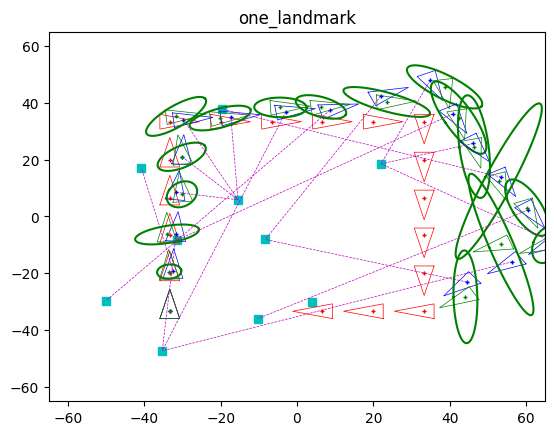

In [11]:
# RUN
mode = 'one_landmark'
# mode = 'landmarks_in_fov'
visualization = 'non_stop'
#visualization = 'step_by_step'

Size=50.0

# Robot base characterization
SigmaX = 0.8 # Standard deviation in the x axis
SigmaY = 0.8 # Standard deviation in the y axis
SigmaTheta = 0.1 # Bearing standar deviation
R = np.diag([SigmaX**2, SigmaY**2, SigmaTheta**2]) # Cov matrix

true_pose = np.vstack([-Size+Size/3, -Size+Size/3, np.pi/2])
robot = Robot(true_pose, R)

# Sensor characterization
SigmaR = 1 # Standard deviation of the range
SigmaB = 0.7 # Standard deviation of the bearing
Q = np.diag([SigmaR**2, SigmaB**2]) # Cov matrix

sensor = Sensor(Q)

main(robot, sensor, mode=mode, visualization=visualization, Size=Size)

### **<span style="color:green"><b><i>ASSIGNMENT 5:  Implementing the FoV of a sensor.</i></b></span>** 

Sensors exhibit certain physical limitations regarding their field of view (FoV) and maximum operating distance (max. Range). Besides, these devices often do not deliver measurmenets from just one landmark each time, but from all those landmarks in the FoV. 

The `FOVSensor()` class below extends the `Sensor()` one to implement this behaviour. Complete the `observe_in_fov()` method to consider that the sensor can only provide information from the landmkars in a limited range $r_l$ and a limited orientation $\pm \alpha$ with respect to the robot pose. For that:

1. Get the observations to every landmark in the map. Use the `observe()` function previously implemented for that, but with the argument `flatten=False`. With that option the function returns the measurements as:
$$
z = \begin{bmatrix} d_1 &  \cdots &  d_m \\ \theta_1 & \cdots & \theta_m \end{bmatrix}
$$
2. Check which observations lay in the sensor FoV and maximum operating distance. *Hint: for that, you can use the [`np.asarray()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.asarray.html) function with the conditions to be fulfilled by the valid measurements inside, and then filter the results with [`np.nonzero()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.nonzero.html)*. 
3. Flatten the resultant matrix `z` to be again a vector, so it has the shape $(2 \times \#Observed\_landmarks,1)$. *Hint: take a look at [`np.ndarray.flatten()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.flatten.html) and choose the proper argument.*

Notice that it could happen that any landmark exists in the field of view of the sensor, so the robot couldn’t gather sensory information in that iteration. This, which is a problem using Least Squares Positioning, is not an issue with EKF. ***Hint: you can change the value of `seed` within the `main()`function to try different executions.***

In [12]:
class FOVSensor(Sensor):
    def __init__(self, cov, fov, max_range):
        super().__init__(cov)
        self.fov = fov
        self.max_range = max_range
    
    def observe_in_fov(self, from_pose, world, noisy=True):
        """ Get all observations in the fov

        Args:
            from_pose: Position(real) of the robot which takes the observation
            world: List of world coordinates of some landmarks
            noisy: Flag, if true then add noise (Exercise 2)

        Returns:
            Numpy array of polar coordinates of landmarks from the perspective of our robot
            They are organised in a vertical vector ls = [d_0 , a_0, d_1, ..., a_n]'
            Dims (2*n_landmarks, 1) 
        """                
        # 1. Get observations to every landmark in the map WITHOUT NOISE
        z = self.observe(from_pose, world, False, False)
        
        # 2. Check which ones lay on the sensor FOV
        angle_limit = self.fov/2 # auxiliar variable
        feats_idx = np.nonzero((z[1]<angle_limit) & (z[1]>-angle_limit) & (z[0]<max_range))[0] # indices of the valid observations
      
        if noisy:
            # 1. Get observations to every landmark in the map WITH NOISE
            z = self.observe(from_pose, world, True, False)
            
        z = z[:, feats_idx] # extracts the valid observations from z
               
        # 3. Flatten the  resultant vector of measurements so z=[d_1,theta_1,d_2,theta_2,...,d_n,theta_n]   
        if z.size>0:
            z = np.vstack(z.flatten('F'))
            
        return z, feats_idx
    
    def draw(self, fig, ax, from_pose):
        """ Draws the Field of View of the sensor from the robot pose """
        return drawFOV(fig, ax, from_pose, self.fov, self.max_range)   

You can now **try** your new and more realistic sensor.

z:[[1.17640523]
 [0.1867558 ]
 [1.84279136]
 [0.49027482]]


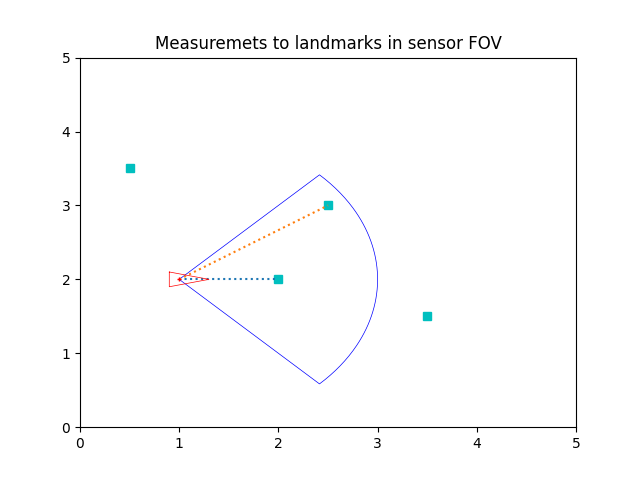

In [15]:
# TRY IT!
np.random.seed(0)

# Create the sensor object
cov = np.diag([0.1**2, 0.1**2]) # Cov matrix
fov = np.pi/2
max_range = 2
sensor = FOVSensor(cov, fov, max_range)

# Create a map with three landmarks
Map = np.array([[2., 2.5, 3.5, 0.5],[2., 3., 1.5, 3.5]])

# Take an observation of landmarks in FoV
robot_pose = np.vstack([1.,2.,0.])
z, feats_idx = sensor.observe_in_fov(robot_pose, Map)
print('z:' +str(z))

# Plot results
fig, ax = plt.subplots()
plt.axis([0, 5, 0, 5])
plt.title('Measuremets to landmarks in sensor FOV')
plt.plot(Map[0,:],Map[1,:],'sc')
sensor.draw(fig, ax, robot_pose)
drawObservations(fig, ax, robot_pose, Map[:, feats_idx])
DrawRobot(fig,ax,robot_pose)

<span style="color:blue">Expected output:</span>
    
```
z:[[1.17640523]
 [0.1867558 ]
 [1.84279136]
 [0.49027482]]
```    

## Playing with EKF and the new sensor

And finally, play with your own FULL implementation of the EKF filter with a more realistic sensor :)

**Example**

The figure below shows an example of the execution of EKF using information from all the landmarks within the FOV:

<figure style="text-align:center">
  <img src="images/fig5-2-2.png" width="500" alt="">
  <figcaption>
      Fig. 2: Execution of the EKF algorithmn for localization. <br/>
      Same as in Fig. 1, except now our robot can observe every <br/> 
      lanmark in its f.o.v. 
  </figcaption>
</figure>

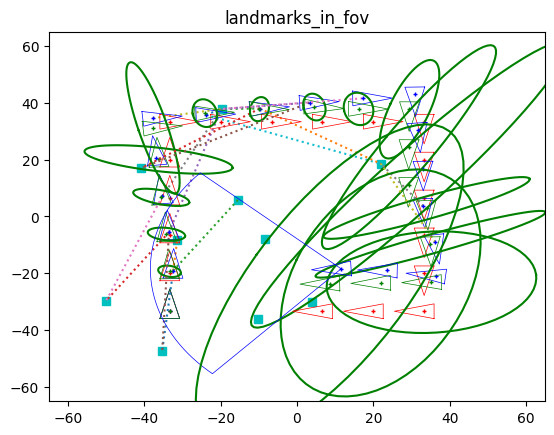

In [17]:
# RUN
#mode = 'one_landmark'
mode = 'landmarks_in_fov'
visualization = 'non_stop'
#visualization = 'step_by_step' 
Size=50.0

# Robot base characterization
SigmaX = 0.8 # Standard deviation in the x axis
SigmaY = 0.8 # Standard deviation in the y axis
SigmaTheta = 0.1 # Bearing standar deviation
R = np.diag([SigmaX**2, SigmaY**2, SigmaTheta**2]) # Cov matrix

true_pose = np.vstack([-Size+Size/3, -Size+Size/3, np.pi/2])
robot = Robot(true_pose, R)

# Sensor characterization
SigmaR = 1 # Standard deviation of the range
SigmaB = 0.7 # Standard deviation of the bearing
Q = np.diag([SigmaR**2, SigmaB**2]) # Cov matrix
fov = np.pi/2 # field of view = 2*alpha
max_range = Size # maximum sensor measurement range

sensor = FOVSensor(Q, fov, max_range)

main(robot, sensor, mode=mode, visualization=visualization, Size=Size)

### <font color="blue"><b><i>Thinking about it (1)</i></b></font>

Having completed the EKF implementation, you are ready to **answer the following questions**:

- What are the dimensions of the Jacobians of the observation model (matrix H)?  Why?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Su dimensión es [num_landmarks * 2, 3] puesto que es el resultado de stackear verticalmente los Jacobianos de las observaciones para formar la matriz H. </i></p>

- Discuss the evolution of the ideal, true and estimated poses when executing the EKF filter (with the initial sensor).

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Mientras que la pose ideal (rojo) es justamente lo que tendría que ocurrir si no hubiera ruido, la pose verdadera (azul) sí está afectada por esa perturbación, por lo que se producen desviaciones en la trayectoria del robot. La pose estimada (verde) es el cálculo que EKF hace en función de las observaciones a los landmarks visibles por el robot durante su trayecto. A medida que el robot los observa, la incertidumbre con respecto a su posición disminuye. Si no ve (casi) ninguno, literalmente se pierde y crece en gran medida. </i></p>

- Discuss the evolution of the ideal, true and estimated poses when executing the EKF filter (with the sensor implementing a FOV). Pay special attention to their associated uncertainties. 

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Lo novedoso de este sensor es que se implementa un rango de visión que limita las observaciones a los landmarks que nuestro robot puede percibir. Como consecuencia de esto, las correcciones se producirán solo si el landmark se encuntra en el rango del sensor (lo cual es bastante realista). Un menor numero de correcciones hace que la incertidumbre crezca bastante más hasta que no veamos un landmark, que hará que decrezca. </i></p>

- What happens in the EKF filter when the robot performs a motion command, but it is unable to measure distances to any landmark, i.e. they are out of the sensor FOV?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Aunque la incertidumbre es enorme (nuestro robot va a ciegas), el filtro EKF sigue siendo capaz de estimar la nueva pose con un sorprendente acercamiento a la pose real.</i></p>